# Copyright Netherlands eScience Center <br>
**Function     : Testing BayesConvLSTM with Lorens-84 model** <br>
**Author       : Yang Liu** <br>
**First Built  : 2020.03.31** <br>
**Last Update  : 2020.04.12** <br>
**Library      : Pytorth, Numpy, NetCDF4, os, iris, cartopy, dlacs, matplotlib**<br>
Description     : This notebook serves to predict the Lorens 84 model using deep learning. The Bayesian Convolutional Long Short Time Memory neural network is used for testing. We use Pytorch as the deep learning framework. <br>
<br>

The Lorens-84 model is described by Edward Lorens in his 1984 paper:<br>
Lorenz, E. N. (1984). Irregularity: A fundamental property of the atmosphere. Tellus A, 36(2), 98-110.<br>

Return Values   : Time series and figures <br>

In [1]:
%matplotlib inline

import sys
import warnings
import numbers

# for data loading
import os
from netCDF4 import Dataset
# for pre-processing and machine learning
import numpy as np
import sklearn
#import scipy
import torch
import torch.nn.functional

#sys.path.append(os.path.join('C:','Users','nosta','ML4Climate','Scripts','DLACs'))
#sys.path.append("C:\\Users\\nosta\\ML4Climate\\Scripts\\DLACs")
sys.path.append("../")
import dlacs
import dlacs.BayesConvLSTM
import dlacs.preprocess
import dlacs.function
import dlacs.saveNetCDF

# for visualization
import dlacs.visual
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
import iris # also helps with regriding
import cartopy
import cartopy.crs as ccrs

# ignore all the DeprecationWarnings by pytorch
if not sys.warnoptions:
    warnings.simplefilter("ignore")

The testing device is Dell Inspirion 5680 with Intel Core i7-8700 x64 CPU and Nvidia GTX 1060 6GB GPU.<br>
Here is a benchmark about cpu v.s. gtx 1060 <br>
https://www.analyticsindiamag.com/deep-learning-tensorflow-benchmark-intel-i5-4210u-vs-geforce-nvidia-1060-6gb/

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2500000,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'rho' : 1026,       # sea water density [kg/m3]
            }

In [60]:
################################################################################# 
#########                           datapath                             ########
#################################################################################
# datapath for output
output_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84'
# data path of experiment
data_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\x_0002\\lorenz'
# datapath of trained bayesconvlstm model
pred_lorenz_bayesconvlstm_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\x_002\\bayes'

In [55]:
if __name__=="__main__":
    #################################################################################
    ###########                configure Lorenz 84 model                  ###########
    #################################################################################
    # name the ensemble member
    ens_num = 10
    # Lorenz paramters and initial conditions
    x_init = 0.99980 # strength of the symmetric globally encircling westerly current
    y_init = 1.0 # strength of the cosine phases of a chain of superposedwaves (large scale eddies)
    z_init = 1.0 # strength of the sine phases of a chain of superposedwaves (large scale eddies)
    F = 8.0 # thermal forcing term
    G = 1.0 # thermal forcing term
    a = 0.25 # stiffness factor for westerly wind x
    b = 4.0 # advection strength of the waves by the westerly current
    
    # assuming the damping time for the waves is 5 days (Lorens 1984)
    dt = 0.0333 # 1/30 unit of time unit (5 days)
    num_steps = 1500
    # cut-off point of initialization period
    cut_off = 300
    # target testing period
    test_len = 200

#### Ensemble<br>
##### Testing benchmark <br>
- Lorenz 84 model set-up <br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0** <br>

##### Testing 
- Testing initial conditions x, y, z - uncertainty of model outcome <br>
**starting point x=1.0, y=1.0, z=1.0** <br>
Ensemble variant x <br>
x = [1.0020, 1.0016, 1.0012, 1.0008, 1.0004, 0.9996, 0.9992, 0.9988, 0.9984, 0.9980] <br>
x = [1.00020, 1.00016, 1.00012, 1.00008, 1.00004, 0.99996, 0.99992, 0.99988, 0.99984, 0.99980] <br>
========================================================================================================<br>
- Testing model parameters a & b - model uncertainty <br>
**starting point a=0.25, b=4.0** <br>
Ensemble variant a <br>
========================================================================================================<br>
- Testing external forcing terms F & G - uncertainty related to extra/bias/trend terms <br>
**starting point F=8.0, G=1.0** <br>
Ensemble variant F <br>

In [40]:
    #################################################################################
    ###########                     Lorens 84 model                       ###########
    #################################################################################    
    def lorenz84(x, y, z, a = 0.25, b = 4.0, F = 8.0, G = 1.0):
        """
        Solver of Lorens-84 model.
        param x, y, z: location in a 3D space
        param a, b, F, G: constants and forcing
        """
        dx = - y**2 - z**2 - a * x + a * F
        dy = x * y - b * x * z - y + G
        dz = b * x * y + x * z - z
        
        return dx, dy, dz
    
    #################################################################################
    ###########            Lorens 84 model + periodic forcing             ###########
    #################################################################################
    def lorenz84_ex(x, y, z, a = 0.25, b = 4.0, F = 8.0, G = 1.0):
        """
        Solver of Lorens-84 model with periodic external forcing.
        The model is designed with a reference to the paper:
        
        param x, y, z: location in a 3D space
        param a, b, F, G: constants and forcing
        """
        dx = - y**2 - z**2 - a * x + a * F * (1)
        dy = x * y - b * x * z - y + G * (1)
        dz = b * x * y + x * z - z
        
        return dx, dy, dz

In [56]:
    #################################################################################
    ###########                 Launch Lorenz 84 model                    ###########
    #################################################################################   
    # Need one more for the initial values
    x = np.empty(num_steps)
    y = np.empty(num_steps)
    z = np.empty(num_steps)
    
    # save initial values
    x[0] = x_init
    y[0] = y_init
    z[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps-1):
        dx, dy, dz = lorenz84(x[i], y[i], z[i])
        x[i + 1] = x[i] + (dx * dt)
        y[i + 1] = y[i] + (dy * dt)
        z[i + 1] = z[i] + (dz * dt)

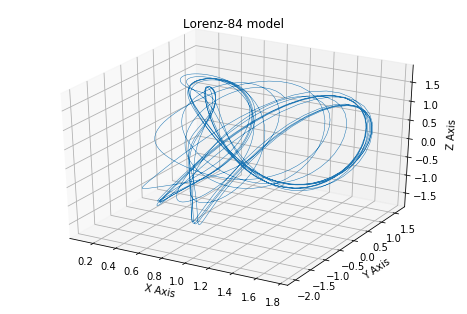

<Figure size 432x288 with 0 Axes>

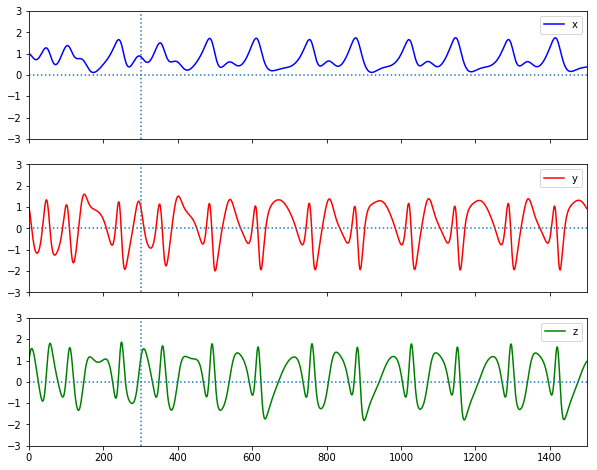

In [57]:
    #################################################################################
    ###########                 Visualize Lorens 84 model                    ###########
    #################################################################################   
    # save Lorens model output
    index = np.arange(num_steps)
    # Plot
    fig00 = plt.figure(figsize=(8,5.4))
    ax = fig00.gca(projection='3d')
    ax.plot(x, y, z, lw=0.5)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title("Lorenz-84 model")
    plt.show()
    fig00.savefig(os.path.join(output_path,
                               'lorenz84_3D_a{}_b{}_F{}_G{}_ens_{}.png'.format(a, b, F, G, ens_num)),dpi=150)
    
    fig01 = plt.figure()
    fig01, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig01.set_size_inches(10, 8, forward=True)
    ax1.plot(index, x, 'b', label='x')
    ax2.plot(index, y, 'r', label='y')
    ax3.plot(index, z, 'g', label='z')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.axvline(x=cut_off, ls = ':')
    ax2.axvline(x=cut_off, ls = ':')
    ax3.axvline(x=cut_off, ls = ':')
    
    ax1.set_xlim(0, num_steps)
    ax2.set_xlim(0, num_steps)
    ax3.set_xlim(0, num_steps)
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)    
    
    ax1.legend()
    ax2.legend()
    ax3.legend()

    plt.show()
    fig01.savefig(os.path.join(output_path,
                               'lorenz84_series_a{}_b{}_F{}_G{}_ens_{}.png'.format(a, b, F, G, ens_num)),dpi=150)

In [8]:
    #################################################################################
    ###########               netCDF module for saving                    ###########
    #################################################################################
    class savenc:
        def __init__(self, datapath, filename):
            """
            Save the output fields into netCDF files.
            """
            print ("Save output fields as netCDF4 files.")
            self.datapath = datapath
            # check if file exists
            if os.path.isfile(os.path.join(datapath, filename)):
                print ("File already exist.")
                raise ValueError('Should use a different name.')
            else:
                self.fileName = filename
        
        def ncfile(self, numpyMatrix):
            """
            Create nc4 file with given dataset. The dataset should contain 4 dimensions.
            """
            # check if the file exist or not
            if os.path.exists(os.path.join(self.datapath,self.fileName)):
                os.remove(os.path.join(self.datapath,self.fileName))
            data_wrap = Dataset(os.path.join(self.datapath,self.fileName), 'w',format = 'NETCDF4')
            # get the dimension of input data
            var, time = numpyMatrix.shape
            # create dimensions for netcdf data
            var_wrap_dim = data_wrap.createDimension('var',var)
            time_wrap_dim = data_wrap.createDimension('time',time)
            # create 1-dimension variables
            var_wrap_var = data_wrap.createVariable('var',np.int32,('var',))
            time_wrap_var = data_wrap.createVariable('time',np.int32,('time',))
            # create 2-dimension variables
            series_wrap_var = data_wrap.createVariable('series',np.float32,('var','time'))
            # global attributes
            data_wrap.description = 'Variables in Laurenz 84 model'
            # variable attributes
            var_wrap_var.units = '1'
            time_wrap_var.units = '1'

            var_wrap_var.long_name = 'number of variables'
            time_wrap_var.long_name = 'time span'
            # writing data
            var_wrap_var[:] = var
            time_wrap_var[:] = time
            series_wrap_var[:] = numpyMatrix
            # close the file
            data_wrap.close()
            print("Create netcdf files successfully!!")

In [58]:
    #################################################################################
    ###########              Save Lorenz 84 model output                  ###########
    #################################################################################
    ncKey = savenc(output_path, 'lorenz84_series_a{}_b{}_F{}_G{}_ens_{}.nc'.format(a, b, F, G, ens_num))
    nc_array = np.zeros((3,num_steps),dtype=float)
    nc_array[0,:] = x[:]
    nc_array[1,:] = y[:]
    nc_array[2,:] = z[:]
    ncKey.ncfile(nc_array)

Save output fields as netCDF4 files.
Create netcdf files successfully!!


===================  load data  =====================
===================  visualize data  =====================
===================  whole time series  =====================


<Figure size 432x288 with 0 Axes>

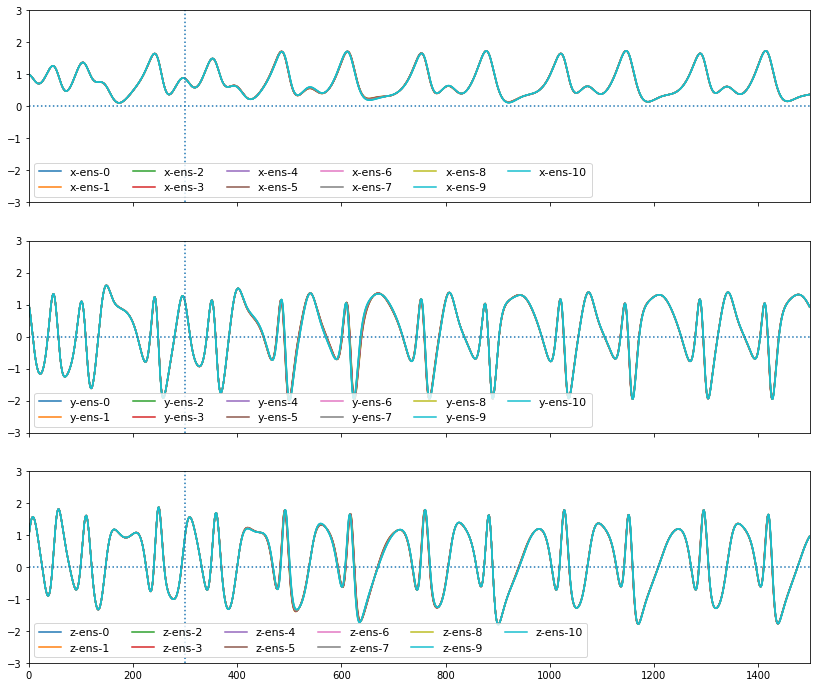

===================  testing period time series  =====================


<Figure size 432x288 with 0 Axes>

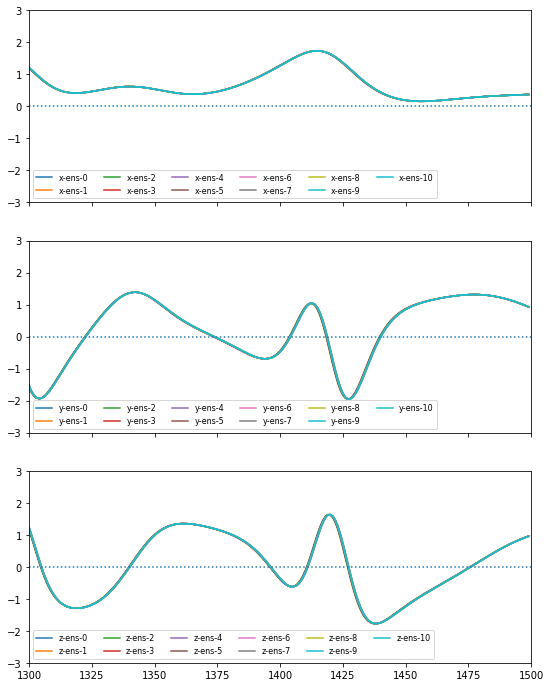

In [61]:
    #################################################################################
    ###########        Precheck Lorenz 84 model ensemble output           ###########
    #################################################################################
    print ('===================  load data  =====================')
    # save Lorens model output
    index = np.arange(num_steps)
    # number of ensembles
    ens = 11
    data_ens = np.zeros((ens, 3, num_steps), dtype=float)
    # load data
    for i in range(ens):
        dataset = Dataset(os.path.join(data_path, 'lorenz84_series_a{}_b{}_F{}_G{}_ens_{}.nc'.format(a, b, F, G, i)))
        data_ens[i,:,:] = dataset.variables['series'][:]
    
    print ('===================  visualize data  =====================')
    #colormap=cm.Pastel2(range(ens))
    #colormap=cm.Accent(range(ens))
    #colormap=cm.Set1(range(ens))
    colormap=cm.tab10(range(ens))
    #colormap=cm.jet(range(ens))
    
    print ('===================  whole time series  =====================')
    fig02 = plt.figure()
    fig02, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig02.set_size_inches(14, 12, forward=True)
    for i in range(ens):
        ax1.plot(index, data_ens[i, 0, :], color=colormap[i], label='x-ens-{}'.format(i))
        ax2.plot(index, data_ens[i, 1, :], color=colormap[i], label='y-ens-{}'.format(i))
        ax3.plot(index, data_ens[i, 2, :], color=colormap[i], label='z-ens-{}'.format(i))
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')

    ax1.axvline(x=cut_off, ls = ':')
    ax2.axvline(x=cut_off, ls = ':')
    ax3.axvline(x=cut_off, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, num_steps)
    ax2.set_xlim(0, num_steps)
    ax3.set_xlim(0, num_steps)
    
    ax1.legend(frameon=True, loc=3, prop={'size': 11}, ncol=6)
    ax2.legend(frameon=True, loc=3, prop={'size': 11}, ncol=6)
    ax3.legend(frameon=True, loc=3, prop={'size': 11}, ncol=6)

    plt.show()
    fig02.savefig(os.path.join(output_path,'lorenz84_series_ens_a{}_b{}_F{}_G{}.png'.format(a, b, F, G)),dpi=200)

    print ('===================  testing period time series  =====================')
    fig03 = plt.figure()
    fig03, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig03.set_size_inches(9, 12, forward=True)
    for i in range(ens):
        ax1.plot(index[-test_len:], data_ens[i, 0, -test_len:], color=colormap[i], label='x-ens-{}'.format(i))
        ax2.plot(index[-test_len:], data_ens[i, 1, -test_len:], color=colormap[i], label='y-ens-{}'.format(i))
        ax3.plot(index[-test_len:], data_ens[i, 2, -test_len:], color=colormap[i], label='z-ens-{}'.format(i))
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(num_steps-test_len, num_steps)
    ax2.set_xlim(num_steps-test_len, num_steps)
    ax3.set_xlim(num_steps-test_len, num_steps)
    
    ax1.legend(frameon=True, loc=3, prop={'size': 8}, ncol=6)
    ax2.legend(frameon=True, loc=3, prop={'size': 8}, ncol=6)
    ax3.legend(frameon=True, loc=3, prop={'size': 8}, ncol=6)

    plt.show()
    fig03.savefig(os.path.join(output_path,'lorenz84_series_ens_testing_a{}_b{}_F{}_G{}.png'.format(a, b, F, G)),dpi=200)

# Forecast with BayesConvLSTM <br>
** We use Pytorth to implement BayesConvLSTM neural network to deal with the Lorenz 84 model output. ** <br>

In [7]:
    print ('*******************  pre-processing  *********************')
    # time series cut-off
    x = x[cut_off:]
    y = y[cut_off:]
    z = z[cut_off:]
    print ('===================  normalize data  =====================')
    x_norm = dlacs.preprocess.operator.normalize(x)
    y_norm = dlacs.preprocess.operator.normalize(y)
    z_norm = dlacs.preprocess.operator.normalize(z)
    print('================  save the normalizing factor  =================')
    x_max = np.amax(x)
    x_min = np.amin(x)
    y_max = np.amax(y)
    y_min = np.amin(y)
    z_max = np.amax(z)
    z_min = np.amin(z)

*******************  pre-processing  *********************
===================  normalize data  =====================
================  save the normalizing factor  =================


In [14]:
    print ('*******************  create basic dimensions for tensor and network  *********************')
    # specifications of neural network
    input_channels = 3
    #hidden_channels = [3, 2, 1] # number of channels & hidden layers, the channels of last layer is the channels of output, too
    hidden_channels = [3]
    kernel_size = 1
    # here we input a sequence and predict the next step only
    #step = 1 # how many steps to predict ahead
    #effective_step = [0] # step to output
    batch_size = 1
    #num_layers = 1
    learning_rate = 0.01
    num_epochs = 1000
    # check the sequence shape
    sequence_len = num_steps - cut_off
    height = 1
    width = 1
    print ('*******************  testing data  *********************')
    test_len = 200
    print ('*******************  check the environment  *********************')
    print ("Pytorch version {}".format(torch.__version__))
    # check if CUDA is available
    use_cuda = torch.cuda.is_available()
    print("Is CUDA available? {}".format(use_cuda))
    # CUDA settings torch.__version__ must > 0.4
    # !!! This is important for the model!!! The first option is gpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")   

*******************  create basic dimensions for tensor and network  *********************
*******************  testing data  *********************
*******************  check the environment  *********************
Pytorch version 1.1.0
Is CUDA available? True


In [9]:
    %%time
    print ('*******************  load exsited LSTM model  *********************')
    # load model parameters
    model = dlacs.BayesConvLSTM.BayesConvLSTM(input_channels, hidden_channels, kernel_size).to(device)
    model.load_state_dict(torch.load(os.path.join(pred_lorenz_bayesconvlstm_path, 'bayesconvlstm_lorenz84_x_002.pkl'),
                                     map_location=device))

*******************  load exsited LSTM model  *********************
!@#$% The network will be built with reduced size BayesConvLSTM cell. !@#$%
Wall time: 7.36 s


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [ ]:
    print ('*******************  run BayesConvLSTM  *********************')
    print ('The model is designed to make many to one prediction.')
    print ('A series of multi-chanel variables will be input to the model.')
    print ('The model learns by verifying the output at each timestep.')
    # initialize our model
    model = dlacs.BayesConvLSTM.BayesConvLSTM(input_channels, hidden_channels, kernel_size).to(device)
    # use Evidence Lower Bound (ELBO) to quantify the loss
    ELBO = dlacs.function.ELBO(height*width)
    # penalty for kl
    penalty_kl = 10
    # stochastic gradient descent
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    # Adam optimizer
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print(model)
    print(ELBO)
    print(optimiser)

In [10]:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print (name)
            print (param.data)
            print (param.size())
            print ("=========================")

cell0.Wxi_mu
tensor([[[[ 0.1492]],

         [[ 0.1480]],

         [[-0.1214]]],


        [[[ 0.1428]],

         [[ 0.1568]],

         [[-0.1162]]],


        [[[ 0.1581]],

         [[ 0.1664]],

         [[-0.1021]]]], device='cuda:0')
torch.Size([3, 3, 1, 1])
cell0.Whi_mu
tensor([[[[-0.0858]],

         [[-0.3030]],

         [[ 0.3695]]],


        [[[ 0.1370]],

         [[ 0.2797]],

         [[-0.3799]]],


        [[[ 0.1469]],

         [[ 0.2906]],

         [[-0.3756]]]], device='cuda:0')
torch.Size([3, 3, 1, 1])
cell0.Wxf_mu
tensor([[[[-0.1075]],

         [[-0.1439]],

         [[ 0.1261]]],


        [[[-0.1372]],

         [[-0.1486]],

         [[-0.1179]]],


        [[[ 0.1407]],

         [[ 0.1505]],

         [[-0.1057]]]], device='cuda:0')
torch.Size([3, 3, 1, 1])
cell0.Whf_mu
tensor([[[[2.3371]],

         [[1.1583]],

         [[1.4146]]],


        [[[1.1734]],

         [[3.3477]],

         [[2.8688]]],


        [[[2.8112]],

         [[3.2182]],

      

In [11]:
    print('##############################################################')
    print('#############  preview model parameters matrix  ###############')
    print('##############################################################')
    print('Number of parameter matrices: ', len(list(model.parameters())))
    for i in range(len(list(model.parameters()))):
        print(list(model.parameters())[i].size())

##############################################################
#############  preview model parameters matrix  ###############
##############################################################
Number of parameter matrices:  20
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])


In [9]:
    %%time
    print('##############################################################')
    print('##################  start training loop  #####################')
    print('##############################################################')
    # track training loss
    hist = np.zeros(num_epochs)
    hist_likelihood = np.zeros(num_epochs)
    hist_complexity = np.zeros(num_epochs)
    # loop of epoch
    for t in range(num_epochs):
        # Clear stored gradient
        model.zero_grad()
        # loop of timestep
        for timestep in range(sequence_len - test_len):
            # hidden state re-initialized inside the model when timestep=0
            #################################################################################
            ########          create input tensor with multi-input dimension         ########
            #################################################################################
            # create variables
            x_input = np.stack((x_norm[timestep], y_norm[timestep], z_norm[timestep])) #vstack,hstack,dstack
            x_var = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width)).to(device)
            #################################################################################
            ########       create training tensor with multi-input dimension         ########
            #################################################################################
            y_train_stack = np.stack((x_norm[timestep+1], y_norm[timestep+1], z_norm[timestep+1])) #vstack,hstack,dstack
            y_var = torch.autograd.Variable(torch.Tensor(y_train_stack).view(-1,hidden_channels[-1],height,width)).to(device)
            #################################################################################   
            # Forward pass
            y_pred, kl_loss, _ = model(x_var, timestep)
            # choose training data
            y_target = y_var
            # torch.nn.functional.mse_loss(y_pred, y_train) can work with (scalar,vector) & (vector,vector)
            # Please Make Sure y_pred & y_train have the same dimension
            # accumulate loss
            if timestep == 0:
                loss, likelihood, complexity = ELBO(y_pred, y_target, kl_loss,
                                                    1 / (len(hidden_channels) * 8 * penalty_kl * kernel_size**2))
            else:
                loss_step, likelihood_step,\
                complexity_step = ELBO(y_pred, y_target, kl_loss,
                                       1 / (len(hidden_channels) * 8 * penalty_kl * kernel_size**2))
                loss += loss_step
                likelihood += likelihood_step
                complexity += complexity_step           
        #print(y_pred.shape)
        #print(y_train.shape)
        # print loss at certain iteration
        if t % 5 == 0:
            print("Epoch {} ELBO: {:0.3f}".format(t, loss.item()))
            print("likelihood cost {:0.3f} #*# complexity cost {:0.3f}".format(likelihood.item(), complexity.item()))
            # gradient check
            # Gradcheck requires double precision numbers to run
            #res = torch.autograd.gradcheck(loss_fn, (y_pred.double(), y_train.double()), eps=1e-6, raise_exception=True)
            #print(res)
        hist[t] = loss.item()
        hist_likelihood[t] = likelihood.item()
        hist_complexity[t] = complexity.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()
    
        # Backward pass
        loss.backward()

        # Update parametersdd
        optimiser.step()
        
    # save the model
    # (recommended) save the model parameters only
    torch.save(model.state_dict(), os.path.join(output_path,'bayesconvlstm_lorenz84.pkl'))
    # save the entire model
    # torch.save(model, os.path.join(output_path,'bayesconvlstm.pkl'))

##############################################################
##################  start training loop  #####################
##############################################################
Epoch 0 ELBO: 617.105
likelihood cost 317.610 #*# complexity cost 299.495
Epoch 5 ELBO: 531.985
likelihood cost 279.987 #*# complexity cost 251.999
Wall time: 6min 9s


*******************  Loss with time  **********************
*******************  Loss with time (log)  **********************


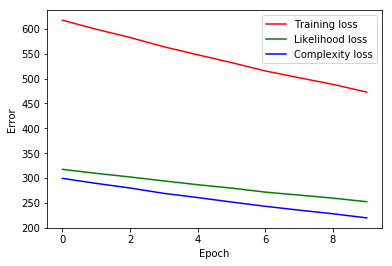

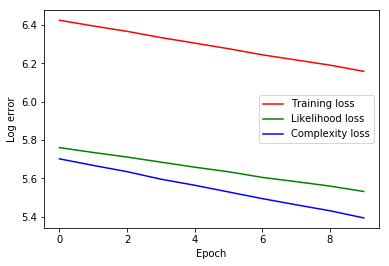

In [11]:
    print ("*******************  Loss with time  **********************")
    fig00 = plt.figure()
    plt.plot(hist, 'r', label="Training loss")
    plt.plot(hist_likelihood, 'g', label="Likelihood loss")
    plt.plot(hist_complexity, 'b', label="Complexity loss")
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    fig00.savefig(os.path.join(output_path,'BayesConvLSTM_pred_error_Lorenz84.png'),dpi=150)
    
    print ("*******************  Loss with time (log)  **********************")
    fig01 = plt.figure()
    plt.plot(np.log(hist), 'r', label="Training loss")
    plt.plot(np.log(hist_likelihood), 'g', label="Likelihood loss")
    plt.plot(np.log(hist_complexity), 'b', label="Complexity loss")
    plt.xlabel('Epoch')
    plt.ylabel('Log error')
    plt.legend()
    plt.show()
    fig01.savefig(os.path.join(output_path,'BayesConvLSTM_pred_log_error_Lorenz84.png'),dpi=150)

# Forecast <br>
**Forecast loop and ensemble generation.** <br>

In [15]:
    %%time
    #################################################################################
    ########  operational lead time dependent prediction with testing data   ########
    #################################################################################
    print('##############################################################')
    print('###################  start prediction loop ###################')
    print('##############################################################')
    # the model learn from time series and try to predict the next time step based on the previous time series
    print ('*******************************  one step ahead forecast  *********************************')
    # time series before test data
    pred_base_x = x_norm[:-test_len]
    pred_base_y = y_norm[:-test_len]
    pred_base_z = z_norm[:-test_len]
    # predict x steps ahead
    step_lead = 16 # unit week
    # ensemble
    ensemble = 5
    # create a matrix for the prediction
    lead_pred_x = np.zeros((test_len,step_lead),dtype=float) # dim [predict time, lead time，lat, lon]
    lead_pred_y = np.zeros((test_len,step_lead),dtype=float) # dim [predict time, lead time，lat, lon]
    lead_pred_z = np.zeros((test_len,step_lead),dtype=float) # dim [predict time, lead time，lat, lon]
    # start the prediction loop
    for ens in range(ensemble):
        print('ensemble No. {}'.format(ens))
        ncKey = dlacs.saveNetCDF.savenc(output_path, 'pred_lorenz84_ens_{}.nc'.format(ens))
        lead_pred_xyz = np.zeros((3, test_len, step_lead), dtype=float)
        for step in range(test_len):
            # Clear stored gradient
            model.zero_grad()
            # Don't do this if you want your LSTM to be stateful
            # Otherwise the hidden state should be cleaned up at each time step for prediction (we don't clear hidden state in our forward function)
            # see example from (https://github.com/pytorch/examples/blob/master/time_sequence_prediction/train.py)
            # model.hidden = model.init_hidden()
            # based on the design of this module, the hidden states and cell states are initialized when the module is called.
            for i in np.arange(1,sequence_len - test_len + step + step_lead, 1): # here i is actually the time step (index) of prediction, we use var[:i] to predict var[i]
                #############################################################################
                ###############           before time of prediction           ###############
                #############################################################################
                if i <= (sequence_len - test_len + step):
                    # create variables
                    x_input = np.stack((x_norm[i-1], y_norm[i-1], z_norm[i-1])) #vstack,hstack,dstack
                    x_var_pred = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width),
                                                         requires_grad=False).to(device)
                    # make prediction
                    last_pred, _, _ = model(x_var_pred, i-1, training=False)
                    # record the real prediction after the time of prediction
                    if i == (sequence_len - test_len + step):
                        lead = 0
                        # GPU data should be transferred to CPU
                        lead_pred_x[step,0] = last_pred[0,0].cpu().data.numpy()
                        lead_pred_y[step,0] = last_pred[0,1].cpu().data.numpy()
                        lead_pred_z[step,0] = last_pred[0,2].cpu().data.numpy()
                #############################################################################
                ###############            after time of prediction           ###############
                #############################################################################
                else:
                    lead += 1
                    # use the predicted data to make new prediction
                    x_input = np.stack((lead_pred_x[step,i-(sequence_len - test_len + step +1)],
                                        lead_pred_y[step,i-(sequence_len - test_len + step +1)],
                                        lead_pred_z[step,i-(sequence_len - test_len + step +1)])) #vstack,hstack,dstack
                    x_var_pred = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width),
                                                         requires_grad=False).to(device)
                    # make prediction
                    last_pred, _, _ = model(x_var_pred, i-1, training=False)
                    # record the prediction
                    lead_pred_x[step,lead] = last_pred[0,0].cpu().data.numpy()
                    lead_pred_y[step,lead] = last_pred[0,1].cpu().data.numpy()
                    lead_pred_z[step,lead] = last_pred[0,2].cpu().data.numpy()
        lead_pred_xyz[0,:,:] = lead_pred_x[:]
        lead_pred_xyz[1,:,:] = lead_pred_y[:]
        lead_pred_xyz[2,:,:] = lead_pred_z[:]
        ncKey.ncfile_Lorenz(lead_pred_xyz)

##############################################################
###################  start prediction loop ###################
##############################################################
*******************************  one step ahead forecast  *********************************
ensemble No. 0
Save output fields as netCDF4 files.
Create netcdf files successfully!!
ensemble No. 1
Save output fields as netCDF4 files.
Create netcdf files successfully!!
ensemble No. 2
Save output fields as netCDF4 files.
Create netcdf files successfully!!
ensemble No. 3
Save output fields as netCDF4 files.
Create netcdf files successfully!!
ensemble No. 4
Save output fields as netCDF4 files.
Create netcdf files successfully!!
Wall time: 2h 12min 23s


# Postprocess forecast data <br>
** Postprocess and visualization of ensemble forecast data ** <br>

In [19]:
    #######################################################################
    #######    Load forecast of Lorenz 84 model by BayesConvLSTM    #######
    #######################################################################
    print ('*******************  load ensemble data  *********************')
    # predict x steps ahead
    step_lead = 16 # unit week
    # number of ensembles
    ens = 5
    predictand = np.zeros((ens, 3, test_len, step_lead), dtype=float)
    for i in range(ens):
        dataset_pred = Dataset(os.path.join(pred_lorenz_bayesconvlstm_path,
                                            'pred_lorenz84_ens_{}.nc'.format(i)))
        predictand[i,:,:,:] = dataset_pred.variables['series'][:]
    print(predictand.shape)
    predictand_median = np.median(predictand, 0)

*******************  load ensemble data  *********************
(5, 3, 200, 16)


===================  visualize data  =====================


<Figure size 432x288 with 0 Axes>

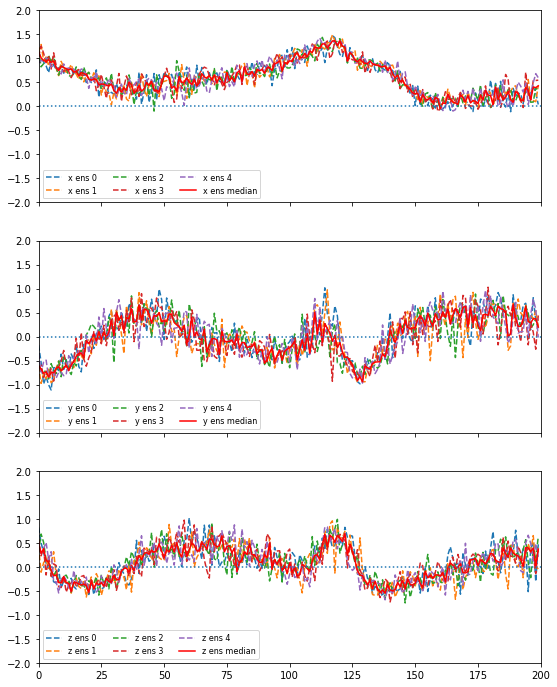

In [35]:
    #######################################################################
    ########    visualization of lead time dependent prediction    ########
    #######################################################################
    index = np.arange(test_len)
    
    print ('===================  visualize data  =====================')
    #colormap=cm.Pastel2(range(ens))
    #colormap=cm.Accent(range(ens))
    #colormap=cm.Set1(range(ens))
    colormap=cm.tab10(range(ens))
    #colormap=cm.jet(range(ens))
    
    fig03 = plt.figure()
    fig03, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig03.set_size_inches(9, 12, forward=True)
    # each member
    for i in range(ens):
        ax1.plot(index, predictand[i, 0, :, 0] * (x_max - x_min) + x_min,
                 color=colormap[i], linestyle='dashed', label='x ens {}'.format(i))
        ax2.plot(index, predictand[i, 1, :, 0] * (y_max - y_min) + y_min,
                 color=colormap[i], linestyle='dashed', label='y ens {}'.format(i))
        ax3.plot(index, predictand[i, 2, :, 0] * (z_max - z_min) + z_min,
                 color=colormap[i], linestyle='dashed', label='z ens {}'.format(i))
    # median
    ax1.plot(index, predictand_median[0, :, 0] * (x_max - x_min) + x_min,
             color='red', linestyle='solid', label='x ens median')
    ax2.plot(index, predictand_median[1, :, 0] * (y_max - y_min) + y_min,
             color='red', linestyle='solid', label='y ens median')
    ax3.plot(index, predictand_median[2, :, 0] * (z_max - z_min) + z_min,
             color='red', linestyle='solid', label='z ens median')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-2, 2)
    ax2.set_ylim(-2, 2)
    ax3.set_ylim(-2, 2)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    ax1.legend(frameon=True, loc=3, prop={'size': 8}, ncol=3)
    ax2.legend(frameon=True, loc=3, prop={'size': 8}, ncol=3)
    ax3.legend(frameon=True, loc=3, prop={'size': 8}, ncol=3)

    plt.show()
    fig03.savefig(os.path.join(output_path,
                               'BayesConvLSTM_forecast_lorenz84_series_ens_a{}_b{}_F{}_G{}.png'.format(a, b, F, G)),dpi=200)

===================  load data  =====================
===================  visualize data  =====================


<Figure size 432x288 with 0 Axes>

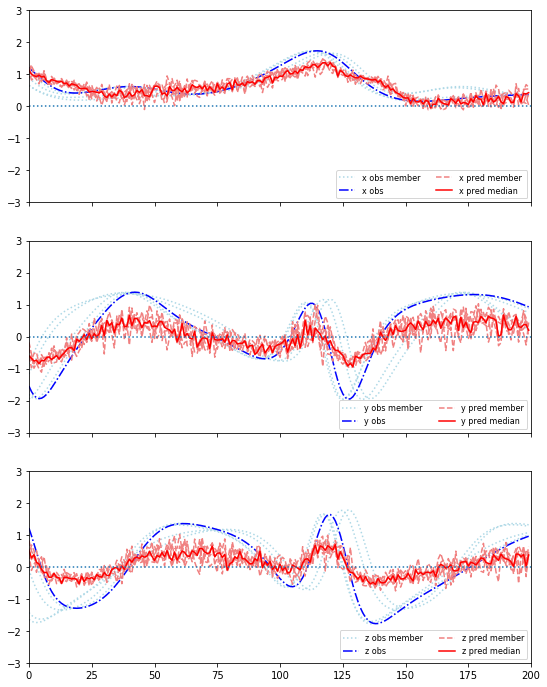

In [34]:
    #############################################################################################################
    ###########        Comparison Lorenz 84 model ensemble output and BayesConvLSTM forecast          ###########
    #############################################################################################################
    print ('===================  load data  =====================')
    # save Lorens model output
    index = np.arange(test_len)
    # number of ensembles
    ens = 5
    ens_lorenz = 11
    data_ens = np.zeros((ens, 3, test_len), dtype=float)
    # load data
    for i in range(ens):
        dataset = Dataset(os.path.join(data_path, 'lorenz84_series_a{}_b{}_F{}_G{}_ens_{}.nc'.format(a, b, F, G, i)))
        data_ens[i,:,:] = dataset.variables['series'][:, -test_len:]

    print ('===================  visualize data  =====================')
    fig04 = plt.figure()
    fig04, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig04.set_size_inches(9, 12, forward=True)
    
    # Lorenz 84 model time series
    for i in range(ens):
        if i == 0: # for the legend
            ax1.plot(index, data_ens[i, 0, :], color='lightblue', linestyle='dotted', label='x obs member')
            ax2.plot(index, data_ens[i, 1, :], color='lightblue', linestyle='dotted',label='y obs member')
            ax3.plot(index, data_ens[i, 2, :], color='lightblue', linestyle='dotted',label='z obs member')
        else:
            ax1.plot(index, data_ens[i, 0, :], color='lightblue', linestyle='dotted')
            ax2.plot(index, data_ens[i, 1, :], color='lightblue', linestyle='dotted')
            ax3.plot(index, data_ens[i, 2, :], color='lightblue', linestyle='dotted')
    
    # without perturbation
    ax1.plot(index, data_ens[0, 0, :], color='blue', linestyle='dashdot', label='x obs')
    ax2.plot(index, data_ens[0, 1, :], color='blue', linestyle='dashdot', label='y obs')
    ax3.plot(index, data_ens[0, 2, :], color='blue', linestyle='dashdot', label='z obs')

    # forecast time series
    for i in range(ens):
        if i == 0: # for the legend
            ax1.plot(index, predictand[i, 0, :, 0] * (x_max - x_min) + x_min,
                     color='lightcoral', linestyle='dashed', label='x pred member ')
            ax2.plot(index, predictand[i, 1, :, 0] * (y_max - y_min) + y_min,
                     color='lightcoral', linestyle='dashed', label='y pred member')
            ax3.plot(index, predictand[i, 2, :, 0] * (z_max - z_min) + z_min,
                     color='lightcoral', linestyle='dashed', label='z pred member')    
        else: 
            ax1.plot(index, predictand[i, 0, :, 0] * (x_max - x_min) + x_min,
                     color='lightcoral', linestyle='dashed')
            ax2.plot(index, predictand[i, 1, :, 0] * (y_max - y_min) + y_min,
                     color='lightcoral', linestyle='dashed')
            ax3.plot(index, predictand[i, 2, :, 0] * (z_max - z_min) + z_min,
                     color='lightcoral', linestyle='dashed')        

    # median forecast time series
    ax1.plot(index, predictand_median[0, :, 0] * (x_max - x_min) + x_min,
             color='red', linestyle='solid', label='x pred median')
    ax2.plot(index, predictand_median[1, :, 0] * (y_max - y_min) + y_min,
             color='red', linestyle='solid', label='y pred median')
    ax3.plot(index, predictand_median[2, :, 0] * (z_max - z_min) + z_min,
             color='red', linestyle='solid', label='z pred median')        
        
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    ax1.legend(frameon=True, loc=4, prop={'size': 8}, ncol=2)
    ax2.legend(frameon=True, loc=4, prop={'size': 8}, ncol=2)
    ax3.legend(frameon=True, loc=4, prop={'size': 8}, ncol=2)

    plt.show()
    fig04.savefig(os.path.join(output_path,
                               'BayesConvLSTM_forecast_lorenz84_series_comp_ens_a{}_b{}_F{}_G{}.png'.format(a, b, F, G)),dpi=200)